# Protect Spaces

This notebook outlines the general workflow for the data within the [Protect Spaces](oceancentral.org/track/protect-spaces) page of the Ocean Central website.

Unless otherwise noted, all polygonal calculations were done in the Mollweide Projection (ESRI:54009)

## Protection Time Series (1)

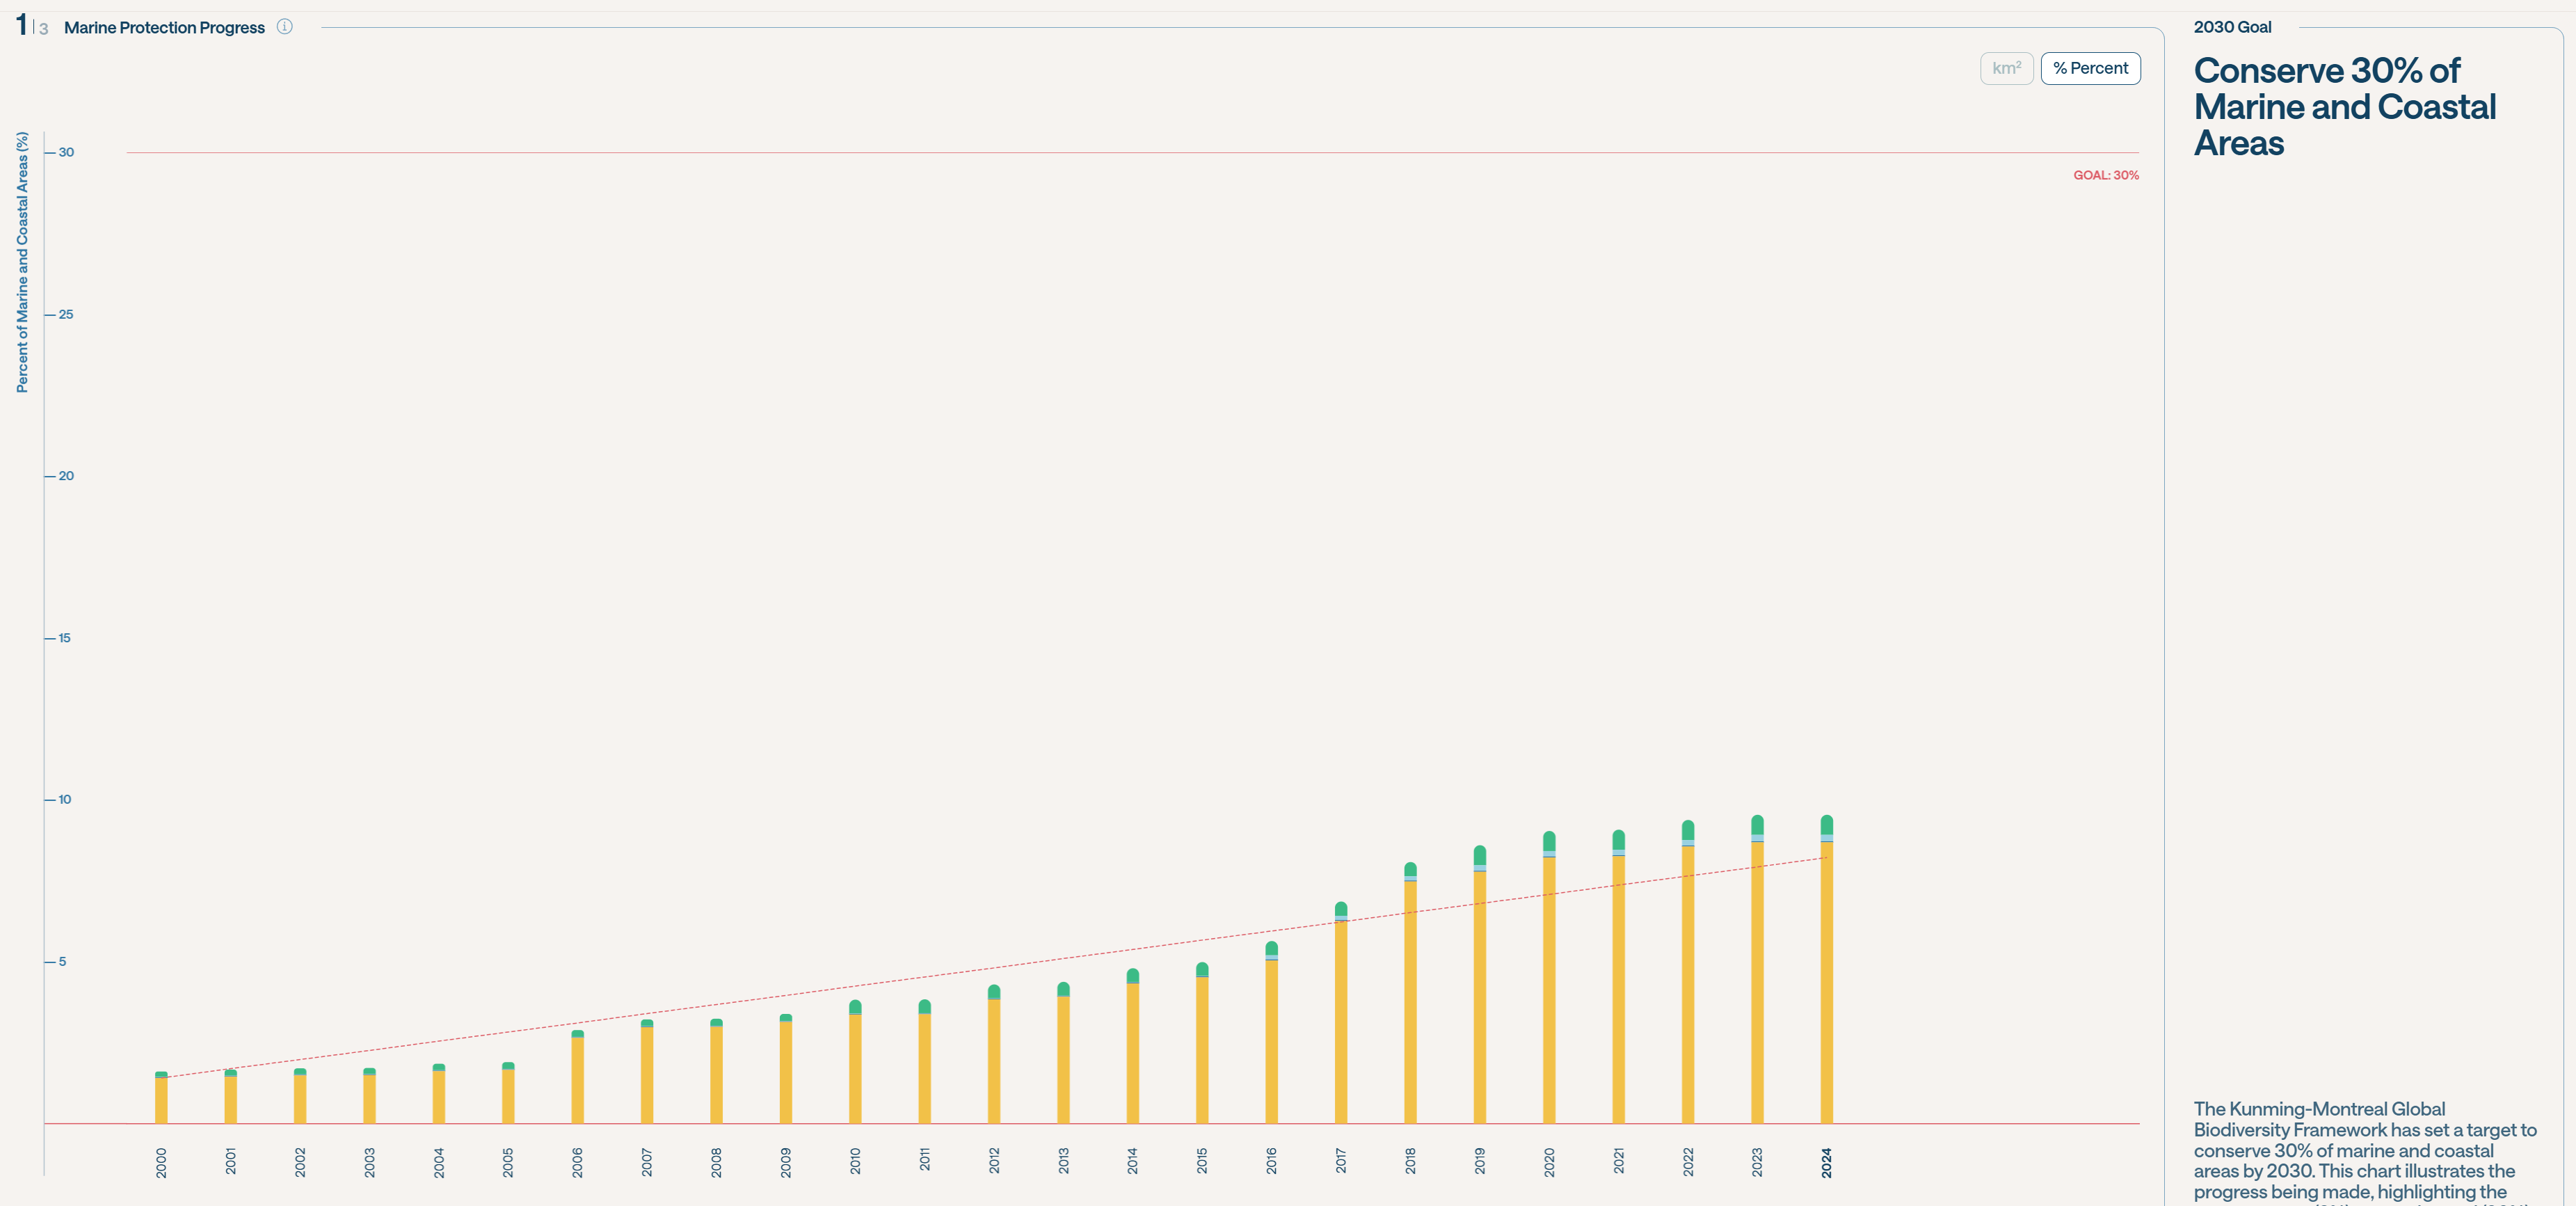

In [ ]:
# This script calculates the area of marine protected areas (MPAs) and other effective conservation measures (OECMs) by year and status.
# We make sure to dissolve polygons within each status and calculate the area of points within each status.
# This allows us to understand the amount of ocean area that is protected or conserved over time.

import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from glob import glob
import argparse

def load_data(shapetype):
    gdfs_polygons = []
    gdfs_points = []
    for filename in tqdm(glob("./data/WDPA_WDOECM_Oct2024_Public_marine_shp/*/*polygons.shp")):
        gdf = gpd.read_file(filename)
        gdfs_polygons.append(gdf)
    for filename in tqdm(glob("./data/WDPA_WDOECM_Oct2024_Public_marine_shp/*/*points.shp")):
        gdf = gpd.read_file(filename)
        gdfs_points.append(gdf)

    mpa_gdf_polygons = pd.concat(gdfs_polygons)
    mpa_gdf_points = pd.concat(gdfs_points)

    if shapetype == 'MPA':
        mpa_gdf_polygons = mpa_gdf_polygons[mpa_gdf_polygons['PA_DEF'] == '1']
        mpa_gdf_points = mpa_gdf_points[mpa_gdf_points['PA_DEF'] == '1']
    elif shapetype == 'OECM':
        mpa_gdf_polygons = mpa_gdf_polygons[mpa_gdf_polygons['PA_DEF'] == '0']
        mpa_gdf_points = mpa_gdf_points[mpa_gdf_points['PA_DEF'] == '0']

    print("Projecting data to Mollweide...")
    mpa_gdf_polygons = mpa_gdf_polygons.to_crs("ESRI:54009")  # Convert to Mollweide projection
    mpa_gdf_points = mpa_gdf_points.to_crs("ESRI:54009")  # Convert to Mollweide projection

    print("Filtering data...")
    mpa_gdf_polygons = mpa_gdf_polygons[mpa_gdf_polygons["MARINE"] != "0"]  # Only keep marine protected areas
    mpa_gdf_points = mpa_gdf_points[mpa_gdf_points["MARINE"] != "0"]  # Only keep marine protected areas

    # Buffer trick fixes invalid geometries
    mpa_gdf_polygons["geometry"] = mpa_gdf_polygons["geometry"].buffer(0)  # Fix invalid geometries
    mpa_gdf_points["geometry"] = mpa_gdf_points["geometry"].buffer(0)  # Fix invalid geometries

    return mpa_gdf_polygons, mpa_gdf_points


def calculate_areas(mpa_gdf_polygons, mpa_gdf_points, start_year, end_year, shapetype):
    results = []
    for year in tqdm(range(start_year, end_year + 1), desc="Processing years"):
        current_polygons = mpa_gdf_polygons[mpa_gdf_polygons["STATUS_YR"] <= year]
        current_points = mpa_gdf_points[mpa_gdf_points["STATUS_YR"] <= year]
        
        # Dissolve polygons within each status
        polygon_areas = current_polygons.dissolve(by='STATUS', aggfunc='sum').to_crs("ESRI:54009")
        polygon_areas['area_km2'] = polygon_areas.geometry.area / 1e6
        
        # Calculate point areas
        point_areas = current_points.groupby('STATUS')['REP_M_AREA'].sum().reset_index()
        point_areas.columns = ['STATUS', 'area_km2']
        
        # Combine polygon and point areas
        combined_areas = pd.concat([polygon_areas['area_km2'], point_areas.set_index('STATUS')['area_km2']])
        combined_areas = combined_areas.groupby('STATUS').sum().reset_index()
        
        combined_areas['year'] = year
        results.append(combined_areas)

        temp_df = pd.concat(results).fillna(0)
        temp_df = temp_df.groupby(['year', 'STATUS'])['area_km2'].sum().reset_index()
        temp_df = temp_df.pivot(index='year', columns='STATUS', values='area_km2').reset_index()
        temp_df = temp_df.fillna(0)
        temp_df = temp_df.round(2)
        temp_df.to_csv(f"mpa_time_series_{shapetype}_{start_year}_{end_year}_temp.csv", index=False)

    final_df = pd.concat(results).fillna(0)
    final_df = final_df.pivot(index='year', columns='STATUS', values='area_km2').reset_index()
    final_df = final_df.fillna(0)
    final_df = final_df.round(2)
    
    return final_df

def main():
    parser = argparse.ArgumentParser(description="Calculate MPA areas by year and status.")
    parser.add_argument('shapetype', type=str, help='All, MPA, or OECM')
    parser.add_argument("--start_year", type=int, help="Start year for calculation")
    parser.add_argument("--end_year", type=int, help="End year for calculation")
    args = parser.parse_args()

    mpa_gdf_polygons, mpa_gdf_points = load_data(args.shapetype)

    print(mpa_gdf_polygons["STATUS"].unique())

    initial_polygons = mpa_gdf_polygons[mpa_gdf_polygons["STATUS_YR"] == 0]
    initial_points = mpa_gdf_points[mpa_gdf_points["STATUS_YR"] == 0]

    initial_statuses = set(initial_polygons["STATUS"]).union(set(initial_points["STATUS"]))

    initial_areas_and_statuses = []
    for status in initial_statuses:
        area = initial_polygons[initial_polygons["STATUS"] == status].geometry.area.sum() / 1e6
        area += initial_points[initial_points["STATUS"] == status]["REP_M_AREA"].sum()
        initial_areas_and_statuses.append({"STATUS": status, "area_km2": area})

    if args.start_year is None:
        args.start_year = min(mpa_gdf_polygons["STATUS_YR"].min(), mpa_gdf_points["STATUS_YR"].min())
    if args.end_year is None:
        args.end_year = max(mpa_gdf_polygons["STATUS_YR"].max(), mpa_gdf_points["STATUS_YR"].max())

    result_df = calculate_areas(mpa_gdf_polygons, mpa_gdf_points, args.start_year, args.end_year, args.shapetype)

    for area_status in initial_areas_and_statuses:
        status = area_status["STATUS"]
        if status not in result_df.columns:
            result_df[status] = 0
        result_df[status] += area_status["area_km2"]
    
    output_file = f"mpa_time_series_{args.shapetype}_{args.start_year}_{args.end_year}.csv"
    result_df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")

if __name__ == "__main__":
    main()

In [ ]:
# The trendline is calculated below. We're choosing to do a simple linear regression for ease of interpretation.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

cumulative_data = pd.read_csv("./mpa_time_series_MPA_final_whittled_w_established.csv")
cumulative_data.rename(columns={"year": "Year"}, inplace=True)
cumulative_data.index = cumulative_data["Year"]

trend_tag = "percent" # "km2" or "percent"

shapetype = "MPA" # "MPA" or "OECM" or "All"

# Assuming cumulative_data is already defined
x = cumulative_data.index.values.reshape(-1, 1)
y = cumulative_data[["Marine Protected Area (MPA)", "Other Effective Area-based Conservation Measure (OECM)"]].sum(axis=1).values

# Shift the x values to start from 0
x_shifted = x - x[0]

# Fit a linear regression model through the origin
model = LinearRegression(fit_intercept=False)
model.fit(x_shifted, y - y[0])

# Calculate the slope and intercept
slope = model.coef_[0]
intercept = y[0]

# Predict values
x_future = np.arange(x[0], 2031).reshape(-1, 1)
y_future = slope * (x_future - x[0]) + intercept

# Plot for local display if needed
# plt.figure(figsize=(12, 6))
# plt.scatter(x, y, label="Real Data", color='blue')
# plt.plot(x_future, y_future, label="Linear Trend", color='red', linestyle='--')
# plt.xlabel("Year")
# plt.ylabel("Area (km²)")
# plt.title("Anchored Linear Trend of Cumulative Area of Marine Protected Areas by 2030")
# plt.legend()
# plt.grid(True)

# Add the equation to the plot
equation = f"y = {slope:.2f}(x - {x[0][0]}) + {intercept:.2f}"
plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

# Print the equation of the line
print(f"Equation of the line: {equation}")

# Calculate R-squared
y_pred = slope * x_shifted + intercept
ss_res = np.sum((y - y_pred)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R-squared: {r_squared:.4f}")

y_future = [y[0] for y in y_future]

# Output trend data
trend_data = pd.DataFrame({
    "Year": x_future.flatten(),
    "Linear Trend": y_future
})
# Merge predictions with real data
data = pd.merge(cumulative_data, trend_data, left_index=True, right_on="Year", how="outer")
data.drop(columns=["Year_x", "Year_y"], inplace=True)
data.to_csv(f"./data_for_export/protected_spaces_1_{shapetype}_{trend_tag}.csv", index=False)

## Global Ecosystem Protection (2)

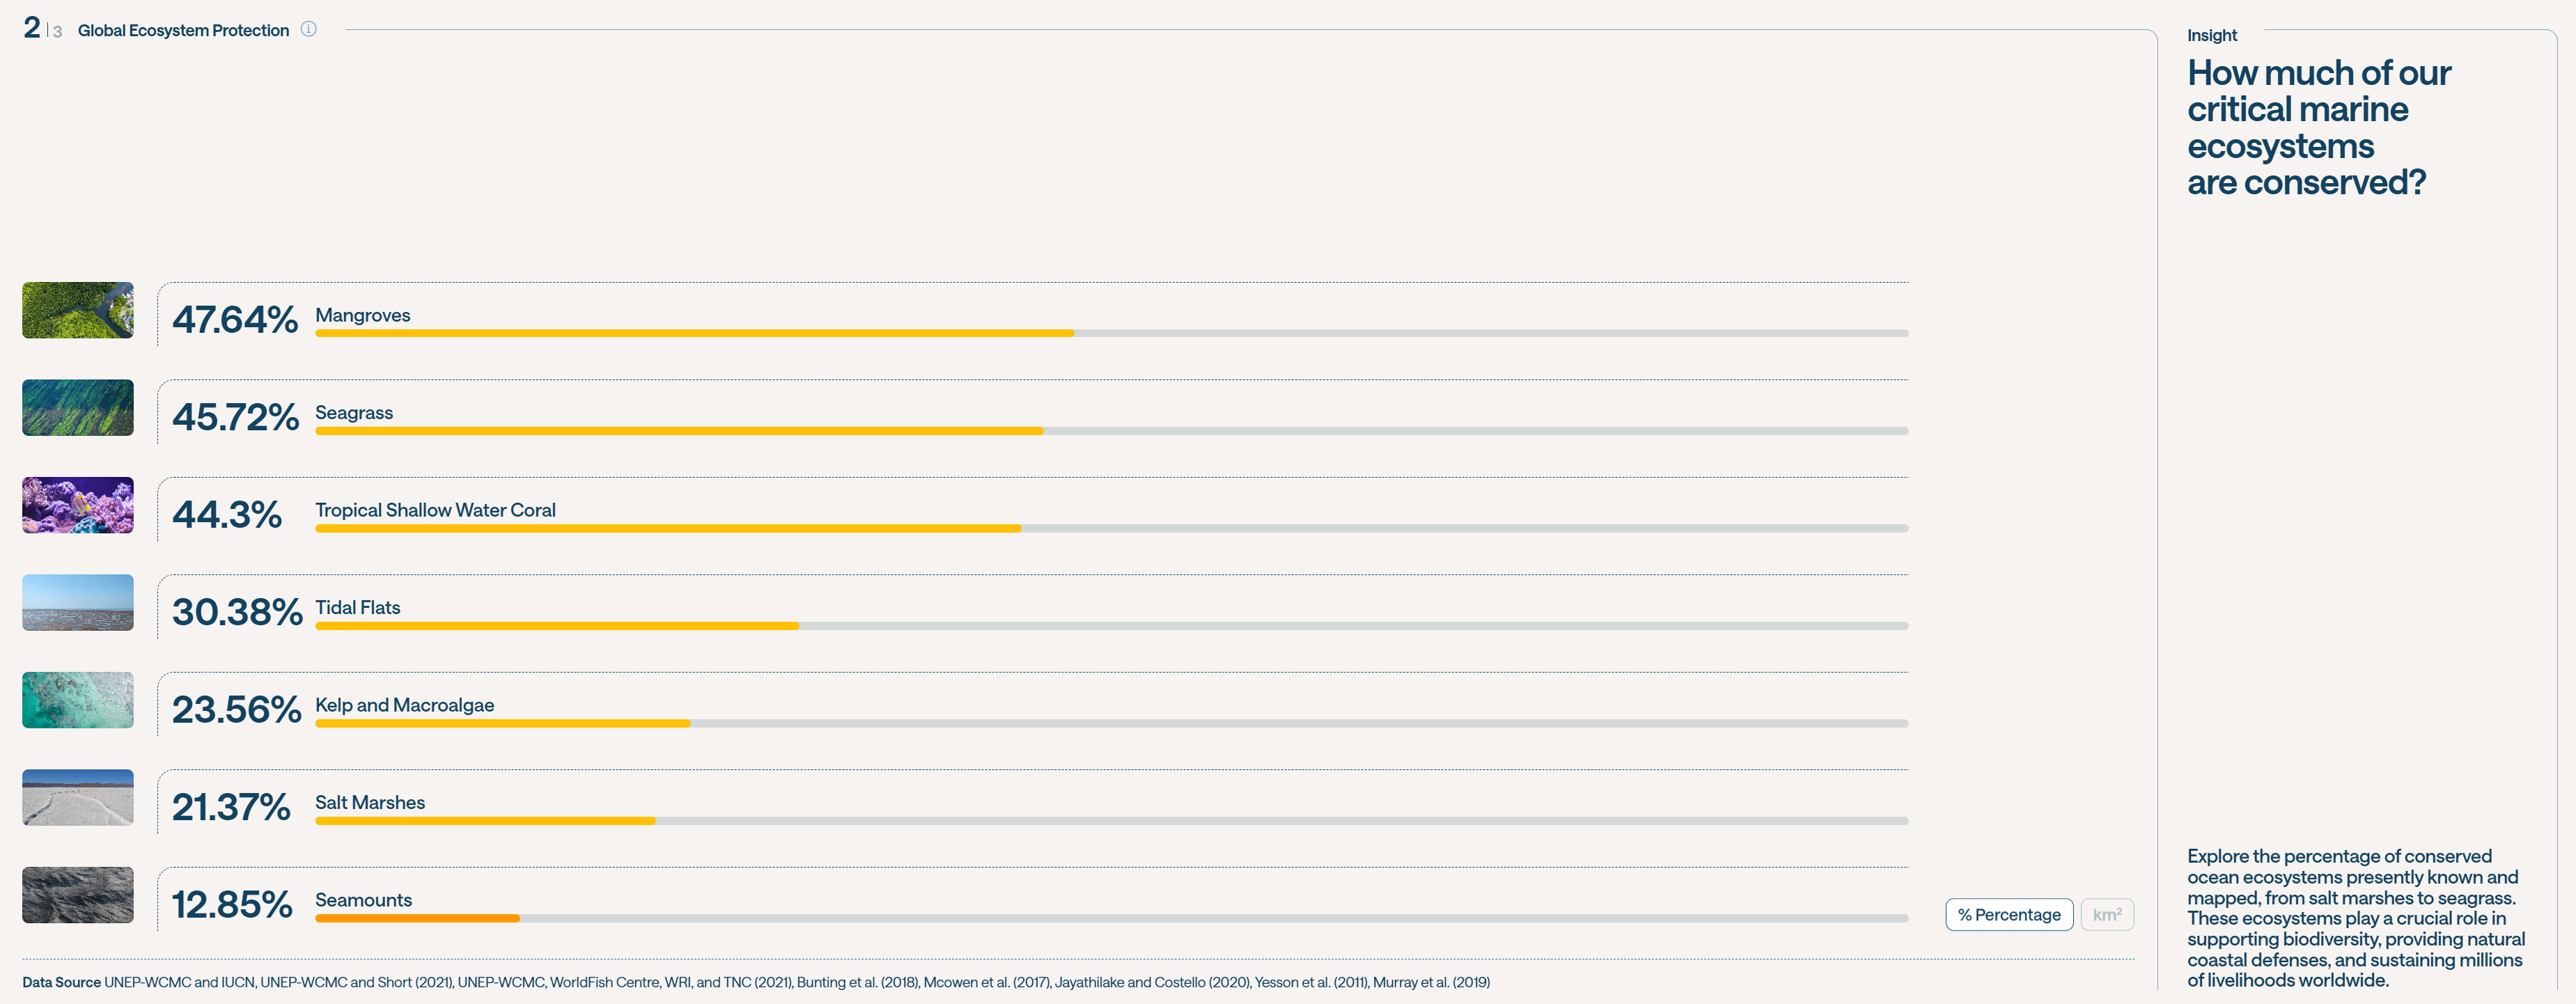

Data processing for this figure was done in QGIS. The following are relevant notes to the process.

1. For those polygons with incorrect geometries, the geometries were corrected with the `Fix Geometries` method.
2. Marine Protected Areas (MPAs) were `dissolved` into a single shape to remove double counting due to overlaps.
3. The ecosystems were also `dissolved` into single shapes for double counting purposes.
4. The `intersection` was taken between the dissolved MPA shape and each of the dissolved ecosystems.
5. The area of the intersection was then divided by the total area of the ecosystem to get the % protected.

Note: For Mangroves, data was taken directly from [Global Mangrove Watch](https://www.globalmangrovewatch.org/?active-widgets=[%22mangrove_protection%22]&layers=[{%22id%22:%22mangrove_protection%22,%22opacity%22:%221%22,%22visibility%22:%22visible%22}]&category=%22all_datasets%22)